In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

%matplotlib inline

In [120]:
class Loader:

    def __init__(self, files):
        self.files = files

    def get_data(self):
        dfs = []
        for file in self.files:
            df = self.load_past_matches(file)
            dfs.append(df)
        
        df_join = self.join_data(dfs[0], dfs[1])

        return df_join

    def load_past_matches(self, file):
        df = pd.read_csv(f'../data/{file}')
        df.drop('Unnamed: 0', axis=1, inplace=True)
        df['date'] = pd.to_datetime(df['date']).dt.date

        return df

    def join_data(self, df1, df2):
        df = pd.merge(df1, df2,  how='inner',
            left_on=['league', 'date','team', 'opponent', 'home'],
            right_on=['league', 'date','team', 'opponent', 'home'])
        df.sort_values(by=['date', 'league', 'team', 'opponent'], inplace=True)
              
        return df

In [121]:
FILES = ["elos_matches.csv", "goals_matches.csv"]
loader = Loader(FILES)
data = loader.get_data()

In [122]:
data.columns

Index(['league', 'date', 'team', 'opponent', 'result', 'elo_team',
       'elo_opponent', 'elo_diff', 'home', 'team_goals_scored',
       'opponent_goals_scored', 'team_goals_conceded',
       'opponent_goals_conceded', 'team_goals_scored_avg',
       'team_goals_conceded_avg', 'team_goals_scored_avg_home',
       'team_goals_conceded_avg_home', 'team_goals_scored_avg_away',
       'team_goals_conceded_avg_away', 'opponent_goals_scored_avg',
       'opponent_goals_conceded_avg', 'opponent_goals_scored_avg_home',
       'opponent_goals_conceded_avg_home', 'opponent_goals_scored_avg_away',
       'opponent_goals_conceded_avg_away', 'league_home_goals_scored',
       'league_away_goals_scored', 'league_home_goals_scored_avg',
       'league_away_goals_scored_avg', 'league_home_goals_conceded',
       'league_away_goals_conceded', 'league_home_goals_conceded_avg',
       'league_away_goals_conceded_avg', 'team_attack_strength',
       'team_defense_strength', 'opponent_attack_strength',
  

In [123]:
data.head()

,league,date,team,opponent,result,elo_team,elo_opponent,elo_diff,home,team_goals_scored,...,league_home_goals_conceded,league_away_goals_conceded,league_home_goals_conceded_avg,league_away_goals_conceded_avg,team_attack_strength,team_defense_strength,opponent_attack_strength,opponent_defense_strength,team_lambda,opponent_lambda
0,Serie A,1997-08-31,atalanta,bologna,1.0,1500.0,1500.0,0.0,1,4,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,Serie A,1997-08-31,bari,parma,0.0,1500.0,1500.0,0.0,1,0,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Serie A,1997-08-31,bologna,atalanta,0.0,1500.0,1500.0,-0.0,0,2,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Serie A,1997-08-31,brescia,inter_milan,0.0,1500.0,1500.0,-0.0,0,1,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,Serie A,1997-08-31,empoli,roma,0.0,1500.0,1500.0,0.0,1,1,...,1.444444,1.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
def build_dataset(df):
    
    df = df.drop(['league', 'date', 'team', 'opponent'], axis=1)
    X = df.drop(['result'], axis=1).to_numpy()
    Y = np.array(df['result'])
    
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).long()
    
    return X, Y

In [125]:
len(data)

83624

In [126]:
n1 = int(0.8 * len(data))
n2 = int(0.9 * len(data))

Xtr, Ytr = build_dataset(data[:n1])
Xdev, Ydev = build_dataset(data[n1:n2])
Xte, Yte = build_dataset(data[n2:])

In [129]:
torch.manual_seed(4); # setting the rng

inputs = Xtr.shape[1]
n_hidden = 100

model = torch.nn.Sequential(
        torch.nn.Linear(inputs, n_hidden, bias=False), torch.nn.BatchNorm1d(n_hidden), torch.nn.Tanh(),
        torch.nn.Linear(n_hidden, n_hidden, bias=False), torch.nn.BatchNorm1d(n_hidden), torch.nn.Tanh(),
        torch.nn.Linear(n_hidden, n_hidden, bias=False), torch.nn.BatchNorm1d(n_hidden), torch.nn.Tanh(),
        torch.nn.Linear(n_hidden, 3)
)

with torch.no_grad():
    model[-1].weight *= 0.1
    
parameters = [p for layer in model for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

24303


In [130]:
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (32, ))
    X, Y = Xtr[ix], Ytr[ix]
    
    # forward pass
    logits = model(X)
    loss = F.cross_entropy(logits, Y)
    
    # backward pass
    for p in parameters:
        p.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update weights
    lr = 0.1 if i < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
#     break

      0/ 100000: 1.0884
  10000/ 100000: 0.1203
  20000/ 100000: 0.0364
  30000/ 100000: 0.0282
  40000/ 100000: 0.0113
  50000/ 100000: 0.1535
  60000/ 100000: 0.1039
  70000/ 100000: 0.0712
  80000/ 100000: 0.0064
  90000/ 100000: 0.0012


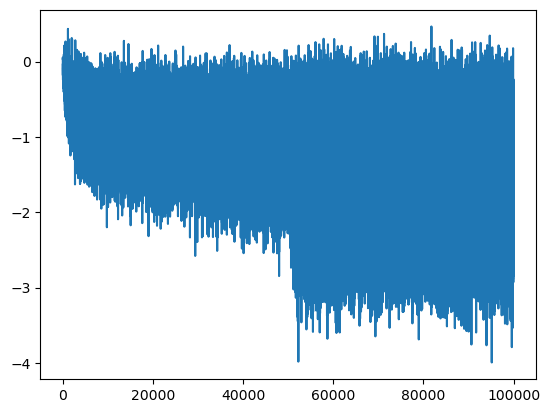

In [131]:
plt.plot(lossi)

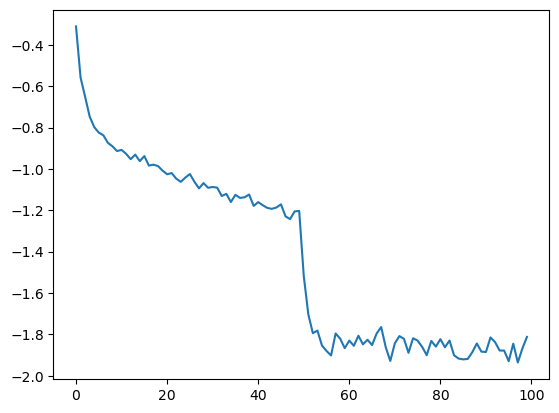

In [132]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [133]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': [Xtr, Ytr],
        'val'  : [Xdev, Ydev],
        'test' : [Xte, Yte]
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [134]:
split_loss('train')
split_loss('val')

train 0.003407026408240199
val 0.0033858767710626125


## Tracker

#### 24,303 parameters, 3 linear layers, 100 n_hidden in each
- Untrained model: train:1.09364, val:1.09389
- Trained model: train:0.003407, val:0.003386